Appended 15 rows to -> C:\Users\admin\Desktop\Khushi\Data Analyst\Mysql Begginers Series\API2.csv
Available metric columns detected: {'1h': 'quote.USD.percent_change_1h', '24h_percent': 'quote.USD.percent_change_24h', '24h_volume': 'quote.USD.volume_change_24h', '7d': 'quote.USD.percent_change_7d', '30d': 'quote.USD.percent_change_30d', '60d': 'quote.USD.percent_change_60d', '90d': 'quote.USD.percent_change_90d'}
Grouped and averaged shape: (15, 7)


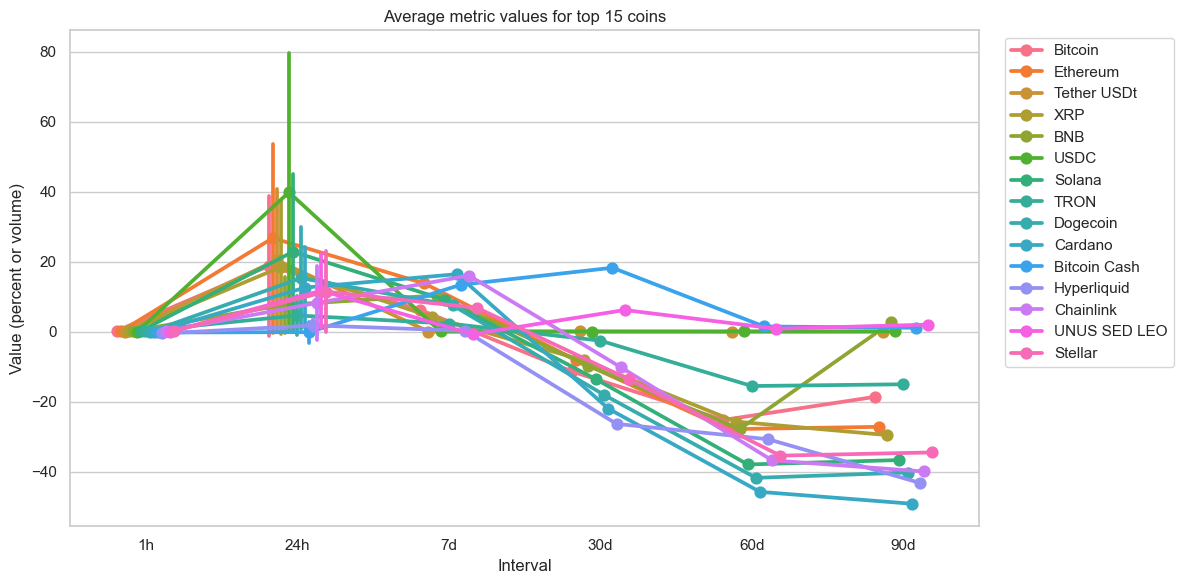

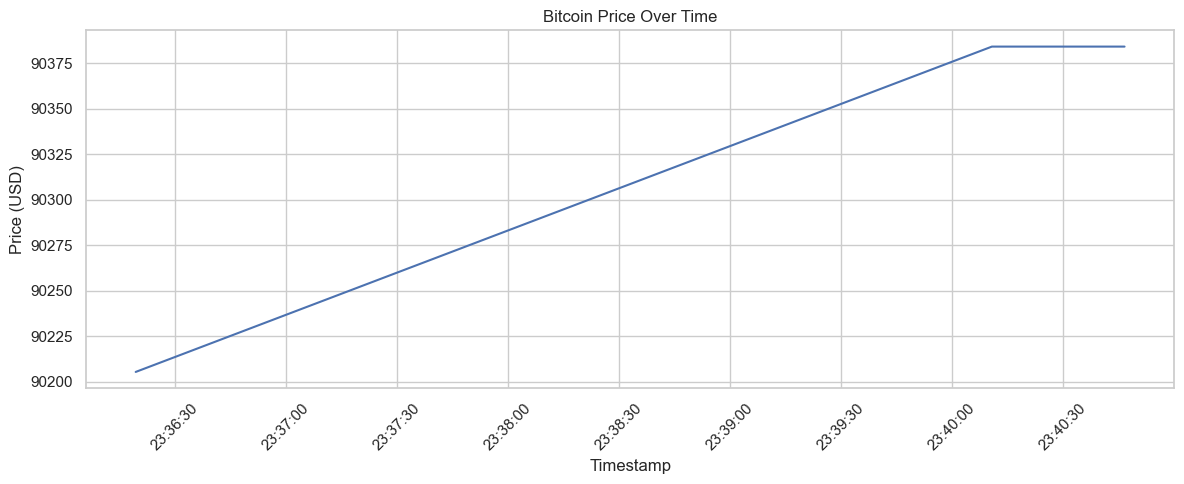

In [4]:
# Robust Crypto fetch + cleaning + plotting (safe, one-run default)
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
import os
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- CONFIG -----------------
CSV_PATH = r'C:\Users\admin\Desktop\Khushi\Data Analyst\Mysql Begginers Series\API2.csv'
API_URL = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
TOP_N = 15
API_KEY = '0ad53085-1cb2-4eb8-ad9e-3ffbd7e56509'   # you asked to keep it here
# -------------------------------------------

# prepare session
session = Session()
session.headers.update({
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY,
})

params = {'start': '1', 'limit': str(TOP_N), 'convert': 'USD'}

def safe_fetch_and_append(csv_path=CSV_PATH, params=params, session=session):
    try:
        resp = session.get(API_URL, params=params, timeout=30)
        resp.raise_for_status()
        payload = resp.json()
    except Exception as e:
        print("ERROR: API request failed:", e)
        return None

    data = payload.get('data', [])
    if not data:
        print("WARNING: API returned no data.")
        return None

    df_new = pd.json_normalize(data)
    df_new['timestamp'] = pd.to_datetime('now')

    # Clean column names (strip whitespace, tabs, newlines)
    df_new.columns = df_new.columns.str.replace('\t', '', regex=True).str.strip()

    # Ensure numeric where appropriate (all quote.USD.* fields)
    quote_cols = [c for c in df_new.columns if c.startswith('quote.USD.')]
    for c in quote_cols:
        df_new[c] = pd.to_numeric(df_new[c], errors='coerce')

    # Save (append) safely
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    if not os.path.isfile(csv_path) or os.path.getsize(csv_path) == 0:
        df_new.to_csv(csv_path, index=False)
        print(f"Created CSV and saved {len(df_new)} rows -> {csv_path}")
    else:
        # Use concat to avoid deprecated append
        # read just the header to check column compatibility (optional)
        df_new.to_csv(csv_path, mode='a', header=False, index=False)
        print(f"Appended {len(df_new)} rows to -> {csv_path}")

    return df_new

# Run a single fetch (safe)
df_fetched = safe_fetch_and_append()

# If you want to run repeated fetches uncomment the following block,
# but beware running in a notebook will block the kernel.
# for i in range(10):
#     safe_fetch_and_append()
#     sleep(60)

# ----------------- POST-PROCESS & PLOTS -----------------
# Read accumulated CSV (if exists)
if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Run fetch first.")

# Read CSV (low_memory to avoid mixed dtype warnings)
df_all = pd.read_csv(CSV_PATH, low_memory=False)

# Clean columns/values
df_all.columns = df_all.columns.str.replace('\t', '', regex=True).str.strip()
for c in df_all.select_dtypes(include=['object']).columns:
    df_all[c] = df_all[c].astype(str).str.strip()

# Convert timestamp and numeric quote columns
if 'timestamp' in df_all.columns:
    df_all['timestamp'] = pd.to_datetime(df_all['timestamp'], errors='coerce')

# Find which metric columns are present
possible_cols = {
    '1h': 'quote.USD.percent_change_1h',
    '24h_percent': 'quote.USD.percent_change_24h',
    '24h_volume': 'quote.USD.volume_change_24h',
    '7d': 'quote.USD.percent_change_7d',
    '30d': 'quote.USD.percent_change_30d',
    '60d': 'quote.USD.percent_change_60d',
    '90d': 'quote.USD.percent_change_90d'
}

available_cols = {k: v for k, v in possible_cols.items() if v in df_all.columns}
print("Available metric columns detected:", available_cols)

if not available_cols:
    raise ValueError("No expected percent/volume columns found. Columns present:\n" + ", ".join(df_all.columns))

# Build list of existing columns to group & average
group_cols = list(available_cols.values())

# Ensure group columns are numeric
for c in group_cols:
    df_all[c] = pd.to_numeric(df_all[c], errors='coerce')

# Group by coin name and average
if 'name' not in df_all.columns:
    raise KeyError("Column 'name' not found in CSV — make sure API returned 'name' field.")

df_group = df_all.groupby('name', sort=False)[group_cols].mean()
print("Grouped and averaged shape:", df_group.shape)

# Reshape into long form for plotting
df_melt = df_group.stack().reset_index()
df_melt.columns = ['name', 'metric_raw', 'value']

# Normalize metric names to friendly labels
def normalize_metric(m):
    m = m.replace('quote.USD.', '')
    m = m.replace('percent_change_', '')
    m = m.replace('volume_change_', '')
    # map 24h volume or percent both to '24h' label
    if m == '24h':
        return '24h'
    return m

df_melt['metric'] = df_melt['metric_raw'].apply(normalize_metric)

# Desired order of categories (keep only those present)
desired_order = ['1h', '24h', '7d', '30d', '60d', '90d']
present_order = [o for o in desired_order if o in df_melt['metric'].unique()]
df_melt['metric'] = pd.Categorical(df_melt['metric'], categories=present_order, ordered=True)

# Drop NaNs before plotting
df_melt = df_melt.dropna(subset=['value'])

# Plot: percent/volume point chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))
ax = sns.pointplot(data=df_melt, x='metric', y='value', hue='name', dodge=True)
ax.set_title(f"Average metric values for top {TOP_N} coins")
ax.set_ylabel("Value (percent or volume)")
ax.set_xlabel("Interval")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot: Bitcoin price over time (if data and column exists)
price_col = 'quote.USD.price'
if price_col in df_all.columns:
    df_all[price_col] = pd.to_numeric(df_all[price_col], errors='coerce')
    df_price = df_all[['name', price_col, 'timestamp']].dropna(subset=[price_col, 'timestamp'])
    df_btc = df_price.query("name == 'Bitcoin'").sort_values('timestamp')
    if not df_btc.empty:
        plt.figure(figsize=(12,5))
        sns.lineplot(data=df_btc, x='timestamp', y=price_col)
        plt.title("Bitcoin Price Over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("Price (USD)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No Bitcoin rows found in CSV for price plot.")
else:
    print(f"Column '{price_col}' not found — skipping Bitcoin price plot.")
